# ML Project

---

## **Part 1:** _Automatically Evaluate Dataset & Generate Algorithm-Selection Graph_

This module implements an automatic algorithm selection strategy inspired by
the scikit‑learn cheat‑sheet. It evaluates a given dataset to determine if the
problem is supervised (and, if so, whether it is classification or regression) or unsupervised (clustering or dimensionality reduction) and builds a decision flow graph that explains every decision made.

### 1.1 Imports & Setup

In [ ]:
!pip install graphviz

import pandas as pd
import numpy as np
from graphviz import Digraph
from typing import List, Dict, Any, Optional, Tuple


---

In [ ]:
class CheatSheetSelector:
    """
    A class that emulates the scikit-learn cheat-sheet decision process.

    The steps include:
      1. Sample size check.
      2. Problem type: supervised (classification or regression) or unsupervised (clustering or dimensionality reduction).
      3. For classification: further decisions based on text data, high dimensionality, and sample size.
      4. For regression: a decision node for linear vs. non-linear relationships and sample size.
      5. For unsupervised: a decision between clustering and dimensionality reduction based on feature count.

    The complete decision path is recorded and a graph is built with labeled nodes and edges.
    """

    def __init__(
        self,
        df: pd.DataFrame,
        target_col: Optional[str] = None,
        sample_threshold_small: int = 50,
        sample_threshold_medium: int = 10_000,
        sample_threshold_large: int = 100_000,
        assume_linear: Optional[bool] = True  # For regression branch
    ):
        """
        :param df: Input DataFrame.
        :param target_col: Name of the target column (if supervised). If None, dataset is treated as unlabeled.
        :param sample_threshold_small: Minimum samples required (e.g., 50).
        :param sample_threshold_medium: Threshold for small vs. medium sample sizes (e.g., 10k).
        :param sample_threshold_large: Threshold for medium vs. large sample sizes (e.g., 100k).
        :param assume_linear: Assumption for regression problems; if True, use linear methods by default.
        """
        self.df = df
        self.target_col = target_col
        self.n_samples = len(df)
        self.sample_threshold_small = sample_threshold_small
        self.sample_threshold_medium = sample_threshold_medium
        self.sample_threshold_large = sample_threshold_large
        self.assume_linear = assume_linear

        # Store the decision path as a list of dicts for text-based debugging/logging
        self.decision_path: List[Dict[str, Any]] = []

        # Graph to render the decision flow
        self.graph = Digraph(name="CheatSheetGraph", comment="Sklearn Cheat-Sheet Decision Flow")
        self.graph.attr(rankdir='LR', size='10,5')  # Left-to-right flow
        self.node_counter = 0  # To create unique node IDs

    # -------------------------------------------------------------------------
    # Graph Helpers
    # -------------------------------------------------------------------------
    def _add_node(self, label: str) -> str:
        """Create a new node in the graph with an incremental ID."""
        node_id = f"node_{self.node_counter}"
        self.graph.node(node_id, label)
        self.node_counter += 1
        return node_id

    def _add_edge(self, from_id: str, to_id: str, edge_label: str = ""):
        """Create an edge in the graph with an optional label."""
        self.graph.edge(from_id, to_id, label=edge_label)

    def _record_decision(self, node_name: str, reason: str):
        """Record a decision step with its explanation (for text-based output)."""
        self.decision_path.append({"node_name": node_name, "reason": reason})

    # -------------------------------------------------------------------------
    # Decision Logic Helpers
    # -------------------------------------------------------------------------
    def _is_supervised(self) -> bool:
        """Determine if the dataset is supervised by checking for the target column."""
        return bool(self.target_col and self.target_col in self.df.columns)

    def _is_classification(self) -> bool:
        """
        Heuristic to determine if the target variable indicates a classification problem.
        If numeric with few unique values, treat it as classification; otherwise, regression.
        """
        if not self._is_supervised():
            return False  # Unlabeled data cannot be classification
        target_data = self.df[self.target_col]
        if pd.api.types.is_numeric_dtype(target_data):
            # If numeric but has few unique values, treat it as classification
            return target_data.nunique() <= 10
        # Non-numeric (string, categorical) → classification
        return True

    # -------------------------------------------------------------------------
    # Classification Decision
    # -------------------------------------------------------------------------
    def _decide_algorithm_classification(self) -> Tuple[str, str]:
        """
        Decide on a classification algorithm based on text data, high-dimensionality,
        and sample size.

        :return: (last_node_id, recommended_algorithm_str)
        """
        # Create a top-level node for classification decisions
        classification_node = self._add_node("Classification Decision")

        # 1) Check if data is high-dimensional: more features than samples
        high_dim_node = self._add_node("More features than samples?")
        self._add_edge(classification_node, high_dim_node, "Start Classification Branch")

        num_features = self.df.shape[1] - 1  # Exclude target column
        if num_features > self.n_samples:
            self._record_decision(
                "High-dimensional Data",
                f"{num_features} features > {self.n_samples} samples. Use LinearSVC, Naive Bayes, or L1-regularized LogisticRegression."
            )
            rec_algo = "LinearSVC, Naive Bayes, or L1-Regularized LogisticRegression"
            # Make a leaf node for final recommendation
            final_node = self._add_node(f"Recommended: {rec_algo}")
            self._add_edge(high_dim_node, final_node, "YES")
            return final_node, rec_algo
        else:
            self._add_edge(high_dim_node, high_dim_node, "NO")  # loop edge for clarity

        # 2) Check if data is text-based
        text_node = self._add_node("Is your data text-based?")
        self._add_edge(high_dim_node, text_node, "Next")

        has_text = any(
            (self.df[col].dtype == object) and (col != self.target_col)
            for col in self.df.columns
        )
        if has_text:
            self._record_decision(
                "Text Data",
                "Detected text data; Naive Bayes or LogisticRegression are strong baselines."
            )
            rec_algo = "Naive Bayes or LogisticRegression (text-based)"
            final_node = self._add_node(f"Recommended: {rec_algo}")
            self._add_edge(text_node, final_node, "YES")
            return final_node, rec_algo
        else:
            self._add_edge(text_node, text_node, "NO")

        # 3) Check sample size for classification
        sample_node = self._add_node(f"Do you have < {self.sample_threshold_large} samples?")
        self._add_edge(text_node, sample_node, "Next")

        if self.n_samples < self.sample_threshold_large:
            self._record_decision(
                "Sample Size (Classification)",
                f"{self.n_samples} < {self.sample_threshold_large}: SVC, KNeighborsClassifier, or MLPClassifier are possible."
            )
            # Check if we have < medium threshold
            small_sample_node = self._add_node(f"Do you have < {self.sample_threshold_medium} samples?")
            self._add_edge(sample_node, small_sample_node, "YES")

            if self.n_samples < self.sample_threshold_medium:
                self._record_decision(
                    "Small Sample Size",
                    f"{self.n_samples} < {self.sample_threshold_medium}: SVC (RBF), KNeighborsClassifier, or MLPClassifier."
                )
                rec_algo = "SVC (RBF), KNeighborsClassifier, or MLPClassifier"
                final_node = self._add_node(f"Recommended: {rec_algo}")
                self._add_edge(small_sample_node, final_node, "YES")
                return final_node, rec_algo
            else:
                self._record_decision(
                    "Medium Sample Size",
                    f"{self.n_samples} between {self.sample_threshold_medium} and {self.sample_threshold_large}: LinearSVC, SGDClassifier, or Naive Bayes."
                )
                rec_algo = "LinearSVC, SGDClassifier, or Naive Bayes"
                final_node = self._add_node(f"Recommended: {rec_algo}")
                self._add_edge(small_sample_node, final_node, "NO")
                return final_node, rec_algo
        else:
            self._record_decision(
                "Large Sample Size (Classification)",
                f"{self.n_samples} >= {self.sample_threshold_large}: Use scalable methods like SGDClassifier or LinearSVC."
            )
            rec_algo = "SGDClassifier or LinearSVC (large-scale classification)"
            final_node = self._add_node(f"Recommended: {rec_algo}")
            self._add_edge(sample_node, final_node, "NO")
            return final_node, rec_algo

    # -------------------------------------------------------------------------
    # Regression Decision
    # -------------------------------------------------------------------------
    def _decide_algorithm_regression(self) -> Tuple[str, str]:
        """
        Decide on a regression algorithm based on the assumption of linearity
        and the sample size.

        :return: (last_node_id, recommended_algorithm_str)
        """
        regression_node = self._add_node("Regression Decision")

        # 1) Check if user assumes linear or non-linear
        linear_node = self._add_node("Assume linear relationship?")
        self._add_edge(regression_node, linear_node, "Start Regression Branch")

        if self.assume_linear:
            self._record_decision(
                "Linear Relationship Assumed",
                "Suggest LinearRegression, Ridge, Lasso, or ElasticNet."
            )
            # 2) Check sample size
            sample_node = self._add_node(f"Do you have < {self.sample_threshold_large} samples?")
            self._add_edge(linear_node, sample_node, "YES")

            if self.n_samples < self.sample_threshold_large:
                # Check number of features
                n_features = self.df.shape[1] - 1
                feature_node = self._add_node("Number of features < 10?")
                self._add_edge(sample_node, feature_node, "YES")

                if n_features < 10:
                    self._record_decision(
                        "Few Features",
                        f"{n_features} features < 10. Lasso or ElasticNet recommended for feature selection + regularization."
                    )
                    rec_algo = "Lasso or ElasticNet"
                    final_node = self._add_node(f"Recommended: {rec_algo}")
                    self._add_edge(feature_node, final_node, "YES")
                    return final_node, rec_algo
                else:
                    self._record_decision(
                        "Many Features",
                        f"{n_features} features >= 10. Suggest RidgeRegression or LinearRegression."
                    )
                    rec_algo = "RidgeRegression or LinearRegression"
                    final_node = self._add_node(f"Recommended: {rec_algo}")
                    self._add_edge(feature_node, final_node, "NO")
                    return final_node, rec_algo
            else:
                self._record_decision(
                    "Large Sample Size (Regression)",
                    f"{self.n_samples} >= {self.sample_threshold_large}. Use SGDRegressor for scalability."
                )
                rec_algo = "SGDRegressor"
                final_node = self._add_node(f"Recommended: {rec_algo}")
                self._add_edge(sample_node, final_node, "NO")
                return final_node, rec_algo
        else:
            self._add_edge(linear_node, linear_node, "NO")
            self._record_decision(
                "Non-linear Relationship Assumed",
                "Consider SVR (RBF), KNeighborsRegressor, DecisionTreeRegressor, ensembles, or MLPRegressor."
            )
            # Check sample size for non-linear
            sample_node = self._add_node(f"Do you have < {self.sample_threshold_large} samples?")
            self._add_edge(linear_node, sample_node, "Next")

            if self.n_samples < self.sample_threshold_large:
                self._record_decision(
                    "Moderate Sample Size (Regression)",
                    f"{self.n_samples} < {self.sample_threshold_large}: SVR, DecisionTreeRegressor, ensembles, or MLPRegressor."
                )
                rec_algo = "SVR, KNeighborsRegressor, DecisionTreeRegressor, or ensemble regressors"
                final_node = self._add_node(f"Recommended: {rec_algo}")
                self._add_edge(sample_node, final_node, "YES")
                return final_node, rec_algo
            else:
                self._record_decision(
                    "Large Sample Size (Non-linear Regression)",
                    f"{self.n_samples} >= {self.sample_threshold_large}: Use SGDRegressor or scalable non-linear methods."
                )
                rec_algo = "SGDRegressor or scalable non-linear methods"
                final_node = self._add_node(f"Recommended: {rec_algo}")
                self._add_edge(sample_node, final_node, "NO")
                return final_node, rec_algo

    # -------------------------------------------------------------------------
    # Clustering Decision
    # -------------------------------------------------------------------------
    def _decide_algorithm_clustering(self) -> Tuple[str, str]:
        """
        Decide on a clustering algorithm based on the sample size.

        :return: (last_node_id, recommended_algorithm_str)
        """
        clustering_node = self._add_node("Clustering Decision")
        self._record_decision(
            "Clustering Path",
            "Unlabeled data. For clustering, if samples < 10k, KMeans or GMM. Otherwise, MiniBatchKMeans or MeanShift."
        )

        # Create a node for sample size check
        sample_node = self._add_node(f"Do you have < {self.sample_threshold_medium} samples?")
        self._add_edge(clustering_node, sample_node, "Start Clustering Branch")

        if self.n_samples < self.sample_threshold_medium:
            self._record_decision(
                "Small/Moderate Sample Size (Clustering)",
                f"{self.n_samples} < {self.sample_threshold_medium}. KMeans or GMM recommended."
            )
            rec_algo = "KMeans or GMM"
            final_node = self._add_node(f"Recommended: {rec_algo}")
            self._add_edge(sample_node, final_node, "YES")
            return final_node, rec_algo
        else:
            self._record_decision(
                "Large Sample Size (Clustering)",
                f"{self.n_samples} >= {self.sample_threshold_medium}. MiniBatchKMeans or MeanShift recommended."
            )
            rec_algo = "MiniBatchKMeans or MeanShift"
            final_node = self._add_node(f"Recommended: {rec_algo}")
            self._add_edge(sample_node, final_node, "NO")
            return final_node, rec_algo

    # -------------------------------------------------------------------------
    # Dimensionality Reduction Decision
    # -------------------------------------------------------------------------
    def _decide_algorithm_dimred(self) -> Tuple[str, str]:
        """
        Decide on a dimensionality reduction algorithm based on the sample size.

        :return: (last_node_id, recommended_algorithm_str)
        """
        dimred_node = self._add_node("Dimensionality Reduction Decision")
        self._record_decision(
            "Dimensionality Reduction Path",
            "Unlabeled data with high-dimensional features. If samples < 10k, Isomap or Spectral Embedding; otherwise RandomizedPCA or TruncatedSVD."
        )

        # Create a node for sample size check
        sample_node = self._add_node(f"Do you have < {self.sample_threshold_medium} samples?")
        self._add_edge(dimred_node, sample_node, "Start DimRed Branch")

        if self.n_samples < self.sample_threshold_medium:
            self._record_decision(
                "Small/Moderate Sample Size (DimRed)",
                f"{self.n_samples} < {self.sample_threshold_medium}. Recommend Isomap or Spectral Embedding."
            )
            rec_algo = "Isomap or Spectral Embedding"
            final_node = self._add_node(f"Recommended: {rec_algo}")
            self._add_edge(sample_node, final_node, "YES")
            return final_node, rec_algo
        else:
            self._record_decision(
                "Large Sample Size (DimRed)",
                f"{self.n_samples} >= {self.sample_threshold_medium}. Recommend RandomizedPCA or TruncatedSVD."
            )
            rec_algo = "RandomizedPCA or TruncatedSVD"
            final_node = self._add_node(f"Recommended: {rec_algo}")
            self._add_edge(sample_node, final_node, "NO")
            return final_node, rec_algo

    # -------------------------------------------------------------------------
    # Main Decision Flow
    # -------------------------------------------------------------------------
    def run(self) -> Tuple[List[Dict[str, Any]], str]:
        """
        Run the full decision-making process:
          1. Check sample size.
          2. Determine if data is supervised (labeled) or unsupervised.
          3. If supervised, check classification or regression.
          4. If unsupervised, check clustering or dimensionality reduction.
          5. Return the decision path and the final recommended algorithm.

        :return: A tuple containing the decision path and the final recommended algorithm.
        """
        # START: Sample size check
        start_id = self._add_node("START: Check Sample Size (> 50 samples?)")

        if self.n_samples <= self.sample_threshold_small:
            # Not enough data
            self._record_decision(
                "Sample Size Check",
                f"Only {self.n_samples} samples (<= {self.sample_threshold_small}). "
                "Recommend more data or specialized small-sample methods."
            )
            insufficient_node = self._add_node("Insufficient Data")
            self._add_edge(start_id, insufficient_node, "NO")
            return self.decision_path, (
                "Insufficient data. Consider gathering more data or using small-sample methods."
            )
        else:
            self._record_decision(
                "Sample Size Check",
                f"{self.n_samples} samples (> {self.sample_threshold_small}). Proceeding."
            )
            pass_node = self._add_node("Sufficient Samples")
            self._add_edge(start_id, pass_node, "YES")

        # PROBLEM TYPE: Supervised vs. Unsupervised
        supervised_node = self._add_node("Do we have a target (labeled data)?")
        self._add_edge(pass_node, supervised_node, "Next")

        if self._is_supervised():
            self._record_decision(
                "Supervised Check",
                "Target column found → supervised learning."
            )
            # Classification vs. Regression
            problem_node = self._add_node("Are you predicting a category or a quantity?")
            self._add_edge(supervised_node, problem_node, "YES (labeled data)")

            if self._is_classification():
                self._record_decision(
                    "Problem Type",
                    "Target appears categorical → classification."
                )
                # Classification branch
                last_node_id, recommended_algo = self._decide_algorithm_classification()
                self._add_edge(problem_node, last_node_id, "Predicting Category")
            else:
                self._record_decision(
                    "Problem Type",
                    "Target appears numeric → regression."
                )
                # Regression branch
                last_node_id, recommended_algo = self._decide_algorithm_regression()
                self._add_edge(problem_node, last_node_id, "Predicting Quantity")
        else:
            self._record_decision(
                "Supervised Check",
                "No target column → unsupervised learning."
            )
            # Clustering vs. Dimensionality Reduction
            unsup_node = self._add_node("Clustering or Dimensionality Reduction?")
            self._add_edge(supervised_node, unsup_node, "NO (unlabeled data)")

            n_features = self.df.shape[1]
            if n_features <= 10:
                self._record_decision(
                    "Unsupervised Task",
                    f"{n_features} features (<= 10). Assuming clustering."
                )
                last_node_id, recommended_algo = self._decide_algorithm_clustering()
                self._add_edge(unsup_node, last_node_id, "Clustering")
            else:
                self._record_decision(
                    "Unsupervised Task",
                    f"{n_features} features (> 10). Assuming dimensionality reduction."
                )
                last_node_id, recommended_algo = self._decide_algorithm_dimred()
                self._add_edge(unsup_node, last_node_id, "Dimensionality Reduction")

        return self.decision_path, recommended_algo

    # -------------------------------------------------------------------------
    # Graph Rendering
    # -------------------------------------------------------------------------
    def render_graph(self, output_filename: str = "decision_flow", view: bool = True):
        """
        Render the decision graph to a file (PDF, PNG, etc.) based on the filename extension.

        :param output_filename: Output file name (with .pdf or .png extension).
        :param view: Whether to open the file after rendering.
        """
        self.graph.render(filename=output_filename, view=view, cleanup=True)

---
Example usage (testing)

In [ ]:
if __name__ == "__main__":
    # Synthetic example dataset
    data = {
        'feature1': [1, 2, 3, 4, 5, 6],
        'feature2': ["text", "text", "text", "text", "text", "text"],
        'y_class': [0, 1, 1, 0, 1, 0]
    }
    df_example = pd.DataFrame(data)

    # Example with a target column (supervised classification)
    cheat_sheet = CheatSheetSelector(df_example, target_col="y_class")
    decision_path, algo = cheat_sheet.run()
    cheat_sheet.render_graph("algorithm_decision_flow_example")  # Generates a PDF/PNG of the decision graph

    print("=== Decision Path ===")
    for step in decision_path:
        print(f"- {step['node_name']}: {step['reason']}")
    print("=== Recommended Algorithm ===")
    print(algo)

    # For an unsupervised example, remove the target column:
    unsupervised_cheat_sheet = CheatSheetSelector(df_example.drop(columns=["y_class"]))
    decision_path_unsup, algo_unsup = unsupervised_cheat_sheet.run()
    unsupervised_cheat_sheet.render_graph("algorithm_decision_flow_unsup", view=False)

    print("\n=== Unsupervised Decision Path ===")
    for step in decision_path_unsup:
        print(f"- {step['node_name']}: {step['reason']}")
    print("=== Recommended Algorithm (Unsupervised) ===")
    print(algo_unsup)

=== Decision Path ===
- Sample Size Check: Only 6 samples (<= 50). Recommend more data or specialized small-sample methods.
=== Recommended Algorithm ===
Insufficient data. Consider gathering more data or using small-sample methods.

=== Unsupervised Decision Path ===
- Sample Size Check: Only 6 samples (<= 50). Recommend more data or specialized small-sample methods.
=== Recommended Algorithm (Unsupervised) ===
Insufficient data. Consider gathering more data or using small-sample methods.


---

## **Part 2:** _Real Dataset Example using kagglehub_

### **Deutsche Bahn Delays** - Automatic Algorithm Selection

In [11]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "DBtrainrides.csv"
df_1 = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "nokkyu/deutsche-bahn-db-delays",
    file_path
)

<ipython-input-11-90bb953726cf>:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df_1 = kagglehub.load_dataset(


100%|██████████| 103M/103M [00:01<00:00, 93.7MB/s]

Extracting zip of DBtrainrides.csv...


In [ ]:
print("\nFirst 5 records of the real dataset:")
print(df_1.head())

real_selector = CheatSheetSelector(df_1, target_col="arrival_delay_m")
decision_path_real, recommendation_real = real_selector.run()
real_selector.render_graph(output_filename="real_algorithm_decision_flow", view=True)
print("\n=== Decision Path (Real Dataset) ===")
for step in decision_path_real:
    print(f"{step['node_name']}: {step['reason']}")
print("=== Recommended Algorithm for Real Dataset ===")
print(recommendation_real)


First 5 records of the real dataset:
                                  ID line  \
0  1573967790757085557-2407072312-14   20   
1    349781417030375472-2407080017-1   18   
2  7157250219775883918-2407072120-25    1   
3    349781417030375472-2407080017-2   18   
4   1983158592123451570-2407080010-3   33   

                                                path   eva_nr  category  \
0  Stolberg(Rheinl)Hbf Gl.44|Eschweiler-St.Jöris|...  8000001         2   
1                                                NaN  8000001         2   
2  Hamm(Westf)Hbf|Kamen|Kamen-Methler|Dortmund-Ku...  8000406         4   
3                                         Aachen Hbf  8000404         5   
4                            Herzogenrath|Kohlscheid  8000404         5   

             station                state    city    zip      long        lat  \
0         Aachen Hbf  Nordrhein-Westfalen  Aachen  52064  6.091499  50.767800   
1         Aachen Hbf  Nordrhein-Westfalen  Aachen  52064  6.091499  50.767800 

### **Global Terrorism Database** - Property Damage Estimation

In [12]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "globalterrorismdb_0718dist.csv"

# Load the latest version
df_2 = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "START-UMD/gtd",
  file_path,
  pandas_kwargs={"encoding": "ISO-8859-1"}
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df_2.head())

<ipython-input-12-42a043e8844d>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df_2 = kagglehub.load_dataset(
/usr/local/lib/python3.11/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


First 5 records:         eventid  iyear  imonth  iday approxdate  extended resolution  country  \
0  197000000001   1970       7     2        NaN         0        NaN       58   
1  197000000002   1970       0     0        NaN         0        NaN      130   
2  197001000001   1970       1     0        NaN         0        NaN      160   
3  197001000002   1970       1     0        NaN         0        NaN       78   
4  197001000003   1970       1     0        NaN         0        NaN      101   

          country_txt  region  ... addnotes scite1 scite2  scite3  dbsource  \
0  Dominican Republic       2  ...      NaN    NaN    NaN     NaN      PGIS   
1              Mexico       1  ...      NaN    NaN    NaN     NaN      PGIS   
2         Philippines       5  ...      NaN    NaN    NaN     NaN      PGIS   
3              Greece       8  ...      NaN    NaN    NaN     NaN      PGIS   
4               Japan       4  ...      NaN    NaN    NaN     NaN      PGIS   

   INT_LOG  INT_IDEO 

In [ ]:
real_selector = CheatSheetSelector(df_2, target_col="propvalue")
decision_path_real, recommendation_real = real_selector.run()
real_selector.render_graph(output_filename="real_algorithm_decision_flow", view=True)
print("\n=== Decision Path (Real Dataset) ===")
for step in decision_path_real:
    print(f"{step['node_name']}: {step['reason']}")
print("=== Recommended Algorithm for Real Dataset ===")
print(recommendation_real)


=== Decision Path (Real Dataset) ===
Sample Size Check: 181691 samples (> 50). Proceeding.
Supervised Check: Target column found → supervised learning.
Problem Type: Target appears numeric → regression.
Linear Relationship Assumed: Suggest LinearRegression, Ridge, Lasso, or ElasticNet.
Large Sample Size (Regression): 181691 >= 100000. Use SGDRegressor for scalability.
=== Recommended Algorithm for Real Dataset ===
SGDRegressor


# **Global Terrorism Database** - Property Damage Estimation

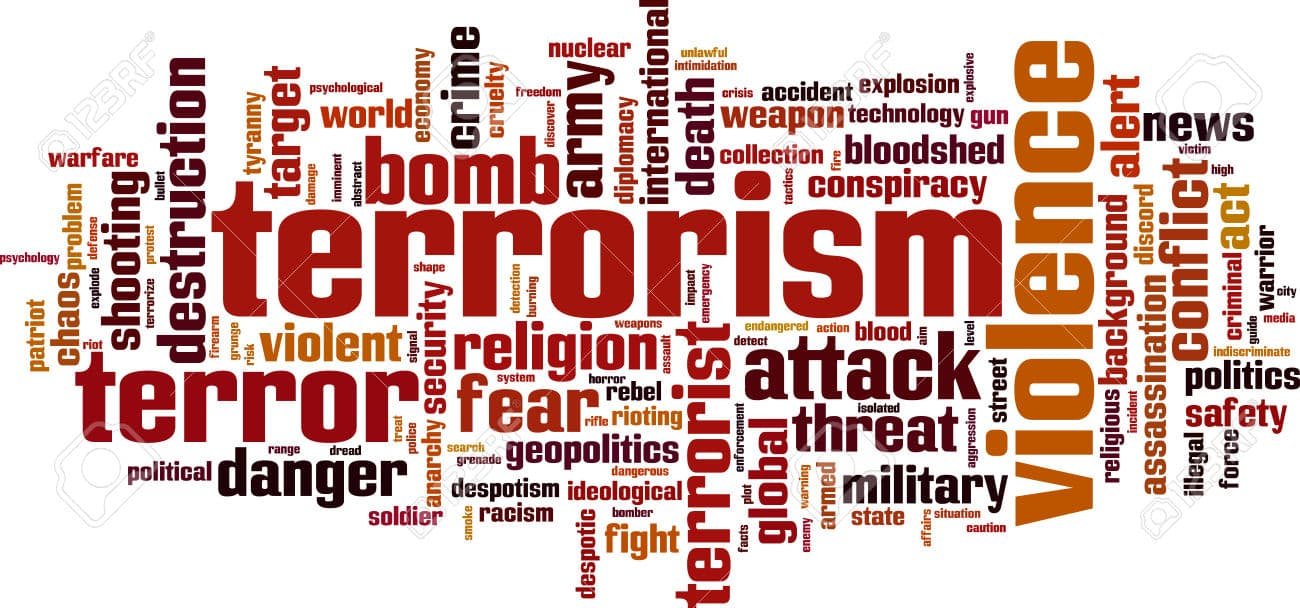

**Dataset Overview**

We will utilize the Global Terrorism Database (GTD) curated by START (National Consortium for the Study of Terrorism and Responses to Terrorism), which contains comprehensive information on over 180,000 terrorist incidents worldwide from 1970 to 2017. The dataset includes variables such as the date and location of the incident, weapon types, target types, responsible groups, number of casualties, and property damage information.

Key features include:

*   Temporal data: year, month and day of the incident
*   Geospatial data: country, region and city
*   Incident characteristics : attack type, target type, weapon type
*   Casualty information: number of people killed or wounded
*   Property damage indicators: whether property damage occurred, extent,  
    and estimated value








**Project Objectives**

This project aims to build a two-stage machine learning system capable of:


*  **Classifying** whether a terrorist incident will cause property damage (**binary classification**).
* **Estimating** the severity of property damage when it occurs (**ordinal classification or regression**).

These predictions can support risk assessment, emergency preparedness, and infrastructure protection strategies by identifying which types of terrorist events are more likely to cause material losses.




**Methodolgy**
We propose the following two-step modeling pipeline:


**Step 1: Property Damage Occurrence Prediction**

*   **Target**: `property` (binary: 1 = damage, 0 = no damage)
*   **Model**: Logistic Regression or Gradient Boosting Classifier
*   **Goal**: Predict whether a terrorist attack will result in any property damage.



**Step 2: Property Damage Severity Prediction**

* **Target Options**:
  * `properxtent` (ordinal classification: e.g., minor to major damage), or
  * `propvalue`  (regression if value is available)

* **Model Options**:
  * Random Forest classifer (for `propextent`)
  * XGBoost Regressor or Linear Regression (for `propvalue`)

* **Goal**: Estimate the extent or monetary value of property damage for incidents where damage occurs.

**Loading the Data**


In [18]:
# Install dependencies as needed:
!pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "globalterrorismdb_0718dist.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "START-UMD/gtd",
  file_path,
  pandas_kwargs={"encoding": "ISO-8859-1"}
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

# Set the path to the file you'd like to load
file_path = "globalterrorismdb_0718dist.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "START-UMD/gtd",
  file_path,
  pandas_kwargs={"encoding": "ISO-8859-1"}
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)



<ipython-input-18-c9520f71ac77>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(
/usr/local/lib/python3.11/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(
<ipython-input-18-c9520f71ac77>:25: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(
/usr/local/lib/python3.11/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


In [19]:
print("First 5 records:", df.head())

First 5 records:         eventid  iyear  imonth  iday approxdate  extended resolution  country  \
0  197000000001   1970       7     2        NaN         0        NaN       58   
1  197000000002   1970       0     0        NaN         0        NaN      130   
2  197001000001   1970       1     0        NaN         0        NaN      160   
3  197001000002   1970       1     0        NaN         0        NaN       78   
4  197001000003   1970       1     0        NaN         0        NaN      101   

          country_txt  region  ... addnotes scite1 scite2  scite3  dbsource  \
0  Dominican Republic       2  ...      NaN    NaN    NaN     NaN      PGIS   
1              Mexico       1  ...      NaN    NaN    NaN     NaN      PGIS   
2         Philippines       5  ...      NaN    NaN    NaN     NaN      PGIS   
3              Greece       8  ...      NaN    NaN    NaN     NaN      PGIS   
4               Japan       4  ...      NaN    NaN    NaN     NaN      PGIS   

   INT_LOG  INT_IDEO 

#### **Exploratory Data Analysis & Visualization**

To understand and visualize delay patterns, the following analyses will be conducted:

1. **Temporal Patterns:**
   - Line chart: Total incidents vs. incidents with property damage per year
   - Area chart: Extent of damage (propextent) over time (later)

2. **Geographical Patterns:**
   - World map (choropleth): Count or intensity of property damage by country (temporary graph)

3. **Categorical Breakdown:**
   - Treemap: Target types by damage extent.
   - Grouped bar chart: Attack types vs. frequency of property damage

#### **Dataset Visualizations**

---

**Temporal Patterns**

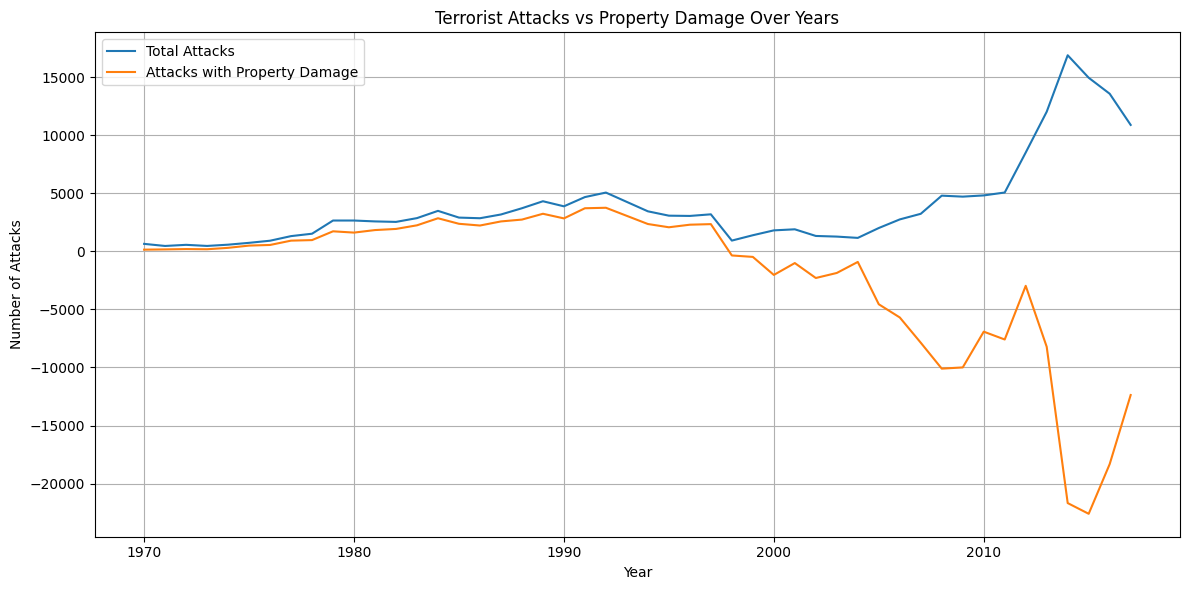

In [22]:
import matplotlib.pyplot as plt

# Use the already-loaded df from kagglehub
df_year = df[['iyear', 'property']].copy()
df_year['property'] = df_year['property'].fillna(0)

# Aggregate
damage_by_year = df_year.groupby('iyear')['property'].sum()
attacks_by_year = df_year.groupby('iyear')['property'].count()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(attacks_by_year.index, attacks_by_year.values, label='Total Attacks')
plt.plot(damage_by_year.index, damage_by_year.values, label='Attacks with Property Damage')
plt.title("Terrorist Attacks vs Property Damage Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Attacks")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Geospatial Analysis**

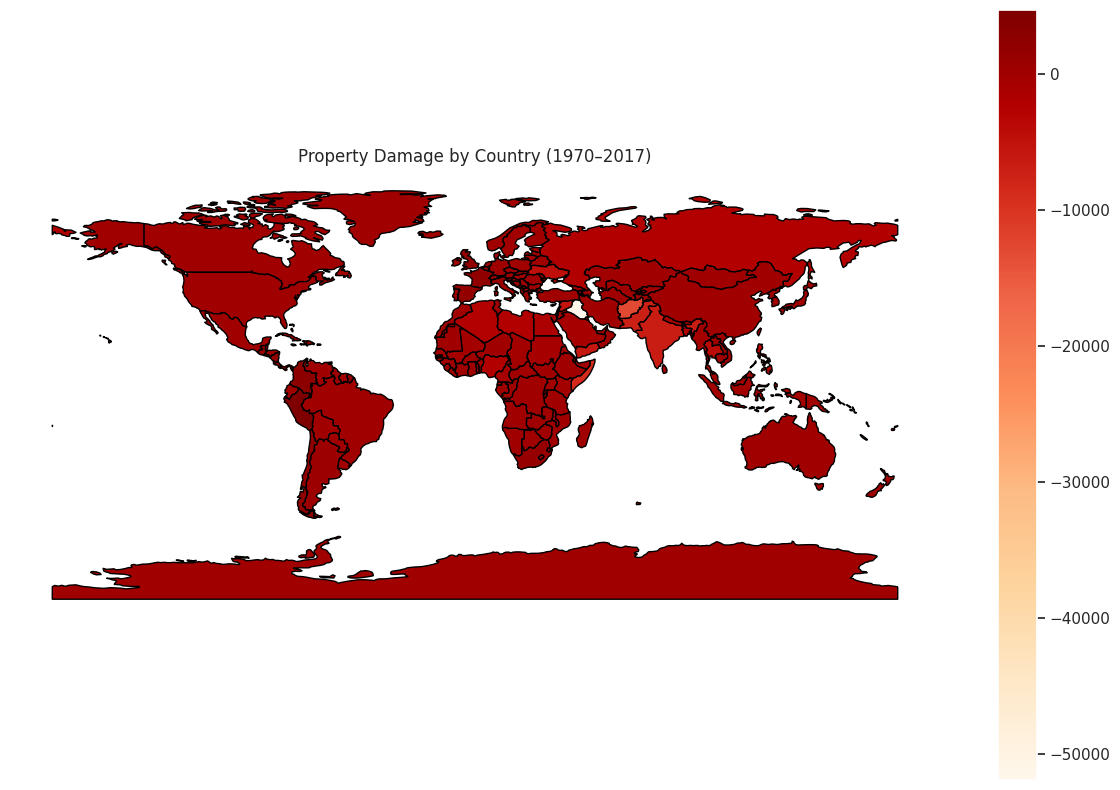

In [30]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load world shapefile directly from Natural Earth via GeoPandas
world = gpd.read_file("https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson")

# Prepare terrorism data for merging
df_geo = df[['country_txt', 'property']].copy()
df_geo['property'] = df_geo['property'].fillna(0)
country_damage = df_geo.groupby('country_txt')['property'].sum().reset_index()

# Merge on country name
world = world.merge(country_damage, how='left', left_on='NAME', right_on='country_txt')
world['property'] = world['property'].fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(column='property', ax=ax, legend=True, cmap='OrRd', edgecolor='black')
ax.set_title("Property Damage by Country (1970–2017)")
ax.axis('off')
plt.show()


**Categorical Analysis**

<ipython-input-31-59067044e93b>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attack_damage.values, y=attack_damage.index, palette='viridis')


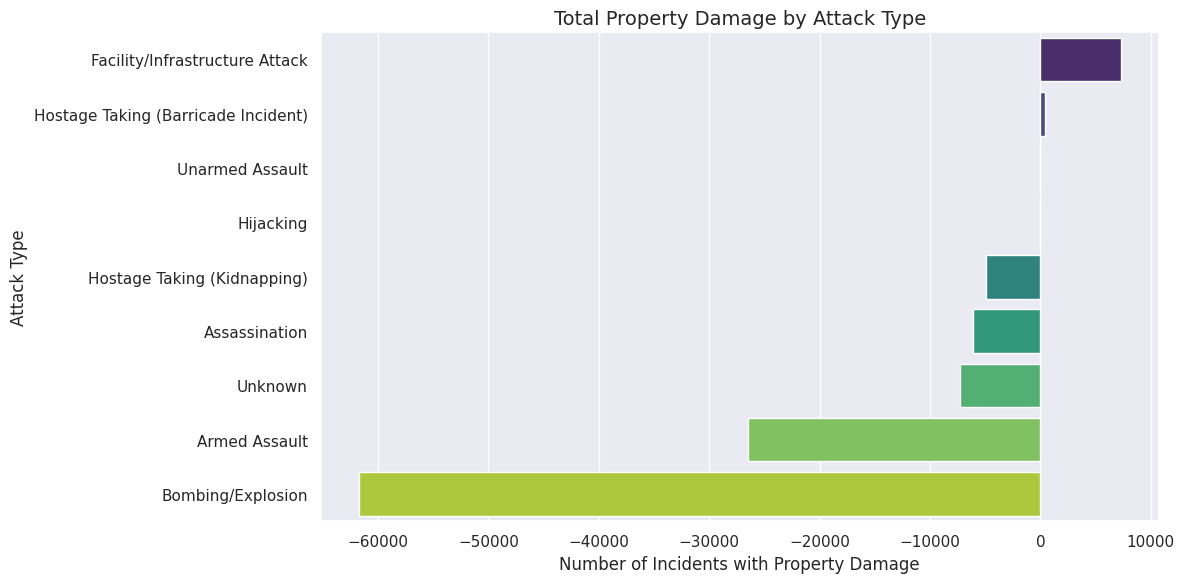

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the relevant columns and clean data
df_cat = df[['attacktype1_txt', 'property']].copy()
df_cat['property'] = df_cat['property'].fillna(0)

# Group by attack type and sum property damage occurrences
attack_damage = df_cat.groupby('attacktype1_txt')['property'].sum().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=attack_damage.values, y=attack_damage.index, palette='viridis')

plt.title("Total Property Damage by Attack Type", fontsize=14)
plt.xlabel("Number of Incidents with Property Damage")
plt.ylabel("Attack Type")
plt.tight_layout()
plt.show()


-----**ITS STILL NOT DONE NEED SOME CHANGES IN THE GRAPHS**-----